Predizendo Preço de games na Steam

In [527]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from sklearn.metrics import  mean_squared_error, mean_absolute_error
import numpy as np


In [528]:
df = pd.read_json('steamdb.json')
df.head(10)

,sid,store_url,store_promo_url,store_uscore,published_store,published_meta,published_stsp,published_hltb,published_igdb,image,...,meta_url,meta_score,meta_uscore,grnk_score,igdb_url,igdb_single,igdb_complete,igdb_score,igdb_uscore,igdb_popularity
0,10,https://store.steampowered.com/app/10,https://www.youtube.com/watch?v=oKC9SAF4JAc,97.0,2000-11-01,2000-11-08,2000-11-01,1999-06-12,1999-06-12,https://steamcdn-a.akamaihd.net/steam/apps/10/...,...,https://www.metacritic.com/game/pc/counter-str...,88.0,92.0,NaN,https://www.igdb.com/games/counter-strike,NaN,NaN,70.0,83.0,25.74
1,20,https://store.steampowered.com/app/20,None,84.0,1999-04-01,1999-04-07,1999-04-01,1999-04-07,1999-04-07,https://steamcdn-a.akamaihd.net/steam/apps/20/...,...,https://www.metacritic.com/game/pc/team-fortre...,NaN,71.0,NaN,https://www.igdb.com/games/team-fortress-classic,NaN,NaN,NaN,70.0,1.67
2,30,https://store.steampowered.com/app/30,https://www.youtube.com/watch?v=j4MCo89bTWE,90.0,2003-05-01,2003-05-06,2003-05-01,2000-08-04,2003-05-01,https://steamcdn-a.akamaihd.net/steam/apps/30/...,...,https://www.metacritic.com/game/pc/day-of-defe...,79.0,91.0,NaN,https://www.igdb.com/games/day-of-defeat,NaN,NaN,71.0,76.0,1.45
3,40,https://store.steampowered.com/app/40,https://www.youtube.com/watch?v=jN_18uhiMS8,82.0,2001-06-01,2001-06-07,2001-06-01,2001-06-01,2001-07-01,https://steamcdn-a.akamaihd.net/steam/apps/40/...,...,https://www.metacritic.com/game/pc/deathmatch-...,NaN,68.0,NaN,https://www.igdb.com/games/deathmatch-classic,NaN,NaN,NaN,75.0,1.00
4,50,https://store.steampowered.com/app/50,https://www.youtube.com/watch?v=ZNZsWm-Ulk4,95.0,1999-11-01,1999-10-31,1999-11-01,1999-11-01,1999-11-10,https://steamcdn-a.akamaihd.net/steam/apps/50/...,...,https://www.metacritic.com/game/pc/half-life-o...,NaN,86.0,NaN,https://www.igdb.com/games/half-life-opposing-...,6.0,4.0,70.0,82.0,3.45
5,60,https://store.steampowered.com/app/60,https://www.youtube.com/watch?v=0NxAdFF0Pv0,81.0,2000-11-01,2000-11-01,2000-11-01,2000-11-01,2000-11-01,https://steamcdn-a.akamaihd.net/steam/apps/60/...,...,https://www.metacritic.com/game/pc/ricochet,NaN,68.0,NaN,https://www.igdb.com/games/ricochet,NaN,NaN,NaN,72.0,2.56
6,70,https://store.steampowered.com/app/70,https://www.youtube.com/watch?v=qobDF0w5qJc,96.0,1998-11-08,1998-11-19,1998-11-08,1998-11-19,1998-11-27,https://steamcdn-a.akamaihd.net/steam/apps/70/...,...,https://www.metacritic.com/game/pc/half-life?f...,96.0,90.0,NaN,https://www.igdb.com/games/half-life,12.0,15.0,80.0,90.0,14.82
7,80,https://store.steampowered.com/app/80,https://www.youtube.com/watch?v=cEoXkWMRD2I,90.0,2004-03-01,2004-01-03,2004-03-01,2004-03-23,2004-03-23,https://steamcdn-a.akamaihd.net/steam/apps/80/...,...,https://www.metacritic.com/game/pc/counter-str...,65.0,87.0,NaN,https://www.igdb.com/games/counter-strike-cond...,NaN,NaN,66.0,75.0,4.12
8,130,https://store.steampowered.com/app/130,https://www.youtube.com/watch?v=vdJwW_0X0Ug,90.0,2001-06-01,2001-06-11,2001-06-01,2001-06-12,2001-06-12,https://steamcdn-a.akamaihd.net/steam/apps/130...,...,https://www.metacritic.com/game/pc/half-life-b...,71.0,82.0,NaN,https://www.igdb.com/games/half-life-blue-shift,4.0,2.0,60.0,72.0,3.67
9,220,https://store.steampowered.com/app/220,https://www.youtube.com/watch?v=ID1dWN3n7q4,97.0,2004-11-16,2004-11-16,2004-11-16,2004-11-16,2004-11-16,https://steamcdn-a.akamaihd.net/steam/apps/220...,...,https://www.metacritic.com/game/pc/half-life-2...,96.0,91.0,NaN,https://www.igdb.com/games/half-life-2,14.0,28.0,91.0,91.0,23.74


In [529]:
df['published_store'] = pd.to_datetime(df['published_store'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53981 entries, 0 to 53980
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   sid                     53981 non-null  int64         
 1   store_url               53981 non-null  object        
 2   store_promo_url         7546 non-null   object        
 3   store_uscore            33462 non-null  float64       
 4   published_store         53831 non-null  datetime64[ns]
 5   published_meta          33603 non-null  object        
 6   published_stsp          19616 non-null  object        
 7   published_hltb          25831 non-null  object        
 8   published_igdb          20965 non-null  object        
 9   image                   53981 non-null  object        
 10  name                    53981 non-null  object        
 11  description             53932 non-null  object        
 12  full_price              46817 non-null  float6

A base de dados têm bastante indices nulos e colunas que não nos dão muita informação como URL do game.
Precisamos retirar itens chave e manter itens que possam ter alguma relevância mas não tenham tantos NaN.

In [530]:

indices_to_drop = [0,1,2,5,6,7,8,9,11,14,15,16,17,18,19,24,26,28,30,32,33,36,37,39,40,41,42,43]

# Obter os nomes das colunas correspondentes aos índices
col_names_to_drop = df.columns[indices_to_drop]

# Remover as colunas
df = df.drop(columns=col_names_to_drop)
df['Idade_do_Produto'] = (datetime.now() - df['published_store']).dt.days
df = df.drop(columns= 'published_store')

In [531]:
df.isna().sum()

store_uscore        20519
name                    0
full_price           7164
current_price        7164
categories             70
genres                  0
tags                33608
achievements        25265
gfq_difficulty      41626
gfq_rating          40490
gfq_length          43271
stsp_owners         18515
hltb_single         39214
hltb_complete       41433
meta_uscore         47969
igdb_uscore         41376
igdb_popularity     32897
Idade_do_Produto      150
dtype: int64

In [532]:
df.dropna().shape

(2128, 18)

In [533]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53981 entries, 0 to 53980
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   store_uscore      33462 non-null  float64
 1   name              53981 non-null  object 
 2   full_price        46817 non-null  float64
 3   current_price     46817 non-null  float64
 4   categories        53911 non-null  object 
 5   genres            53981 non-null  object 
 6   tags              20373 non-null  object 
 7   achievements      28716 non-null  float64
 8   gfq_difficulty    12355 non-null  object 
 9   gfq_rating        13491 non-null  float64
 10  gfq_length        10710 non-null  float64
 11  stsp_owners       35466 non-null  float64
 12  hltb_single       14767 non-null  float64
 13  hltb_complete     12548 non-null  float64
 14  meta_uscore       6012 non-null   float64
 15  igdb_uscore       12605 non-null  float64
 16  igdb_popularity   21084 non-null  float6

In [534]:
df.nunique()

store_uscore          100
name                53708
full_price            157
current_price         428
categories           4662
genres               1795
tags                15697
achievements          411
gfq_difficulty          9
gfq_rating            339
gfq_length            715
stsp_owners            13
hltb_single           129
hltb_complete         282
meta_uscore            85
igdb_uscore            82
igdb_popularity       378
Idade_do_Produto     3763
dtype: int64

Podemos categorizar a dificuldade e tentar expandir os multivalorados 'categories' e 'tags'

In [535]:
df['gfq_difficulty'] = df['gfq_difficulty'].astype('category')

df['name']=df['name'].astype('string')

In [536]:
df['genres'].unique()

array(['Action', 'Action,Free to Play', 'Action,Free to Play,Strategy',
       ...,
       'Adventure,Casual,Free to Play,Massively Multiplayer,Simulation,Sports',
       'Action,Adventure,Free to Play,Indie,Sports',
       'Action,Indie,Racing,RPG'], dtype=object)

In [537]:
df['categories'] = df['categories'].apply(lambda x: x.split(',') if x is not None else [])
df['genres'] = df['genres'].apply(lambda x: x.split(',') if x is not None else [])
df['tags'] = df['tags'].apply(lambda x: x.split(',') if x is not None else [])
df.head()

,store_uscore,name,full_price,current_price,categories,genres,tags,achievements,gfq_difficulty,gfq_rating,gfq_length,stsp_owners,hltb_single,hltb_complete,meta_uscore,igdb_uscore,igdb_popularity,Idade_do_Produto
0,97.0,Counter-Strike,999.0,999.0,"[Multi-player, PvP, Online PvP, Shared/Split S...",[Action],"[Action, FPS, Multiplayer, Shooter, Classic, T...",NaN,Just Right-Tough,3.90,64.5,15000000.0,NaN,NaN,92.0,83.0,25.74,8436.0
1,84.0,Team Fortress Classic,499.0,499.0,"[Multi-player, PvP, Online PvP, Shared/Split S...",[Action],"[Action, FPS, Multiplayer, Classic, Shooter, C...",NaN,Just Right-Tough,3.47,50.6,3500000.0,NaN,NaN,71.0,70.0,1.67,9016.0
2,90.0,Day of Defeat,499.0,499.0,"[Multi-player, Valve Anti-Cheat enabled]",[Action],"[FPS, World War II, Multiplayer, Action, Shoot...",NaN,Just Right-Tough,3.69,53.1,7500000.0,NaN,NaN,91.0,76.0,1.45,7525.0
3,82.0,Deathmatch Classic,499.0,499.0,"[Multi-player, PvP, Online PvP, Shared/Split S...",[Action],"[Action, FPS, Multiplayer, Classic, Shooter, F...",NaN,Just Right-Tough,3.15,2.9,7500000.0,NaN,NaN,68.0,75.0,1.00,8224.0
4,95.0,Half-Life: Opposing Force,499.0,499.0,"[Single-player, Multi-player, Valve Anti-Cheat...",[Action],"[FPS, Action, Sci-fi, Singleplayer, Classic, S...",NaN,Just Right,3.88,10.7,7500000.0,5.0,7.0,86.0,82.0,3.45,8802.0


In [538]:
colunas_para_verificar = ['tags', 'categories', 'genres']

# Contando valores únicos para cada coluna
for coluna in colunas_para_verificar:
    # Achatar a lista de listas
    itens_achatados = [item for sublist in df[coluna].dropna() for item in sublist]

    # Obter os valores únicos
    itens_unicos = set(itens_achatados)

    # Contar e exibir o número de itens únicos
    print(f"Número de itens únicos em '{coluna}': {len(itens_unicos)}")

Número de itens únicos em 'tags': 342
Número de itens únicos em 'categories': 41
Número de itens únicos em 'genres': 20


Temos portanto um grande número de generos e categorias e ainda maior de tags. 
Expandir esses indices pode levar a um número muito extenso de colunas e valores para administrar, isso seria adequado para outros tipos de modelo, diferentes dos que estamos trabalhando na matéria. portanto vamos trabalhar apenas com as outras colunas.

In [539]:
# Instanciar o MultiLabelBinarizer para fazer o one-hot encoding
combined_labels = df.apply(lambda x: set(x['categories'] + x['genres'] + x['tags']), axis=1)

# Instanciar o MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Aplicar o one-hot encoding
combined_encoded = pd.DataFrame(mlb.fit_transform(combined_labels), columns=mlb.classes_, index=df.index)

# Concatenar com o DataFrame original
df_encoded = pd.concat([df, combined_encoded], axis=1)

df_encoded.shape

(53981, 401)

In [540]:
df_encoded = df_encoded.dropna()
df_encoded = df_encoded.drop(columns='full_price')
df_encoded['Multi'] = df_encoded['Multi-player'] | df_encoded['Multiplayer']
#df_encoded = df_encoded.drop(columns=['Multiplayer', 'Multi-player'])

C:\Users\Lucia\AppData\Local\Temp\ipykernel_16364\1320709371.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_encoded.corr()


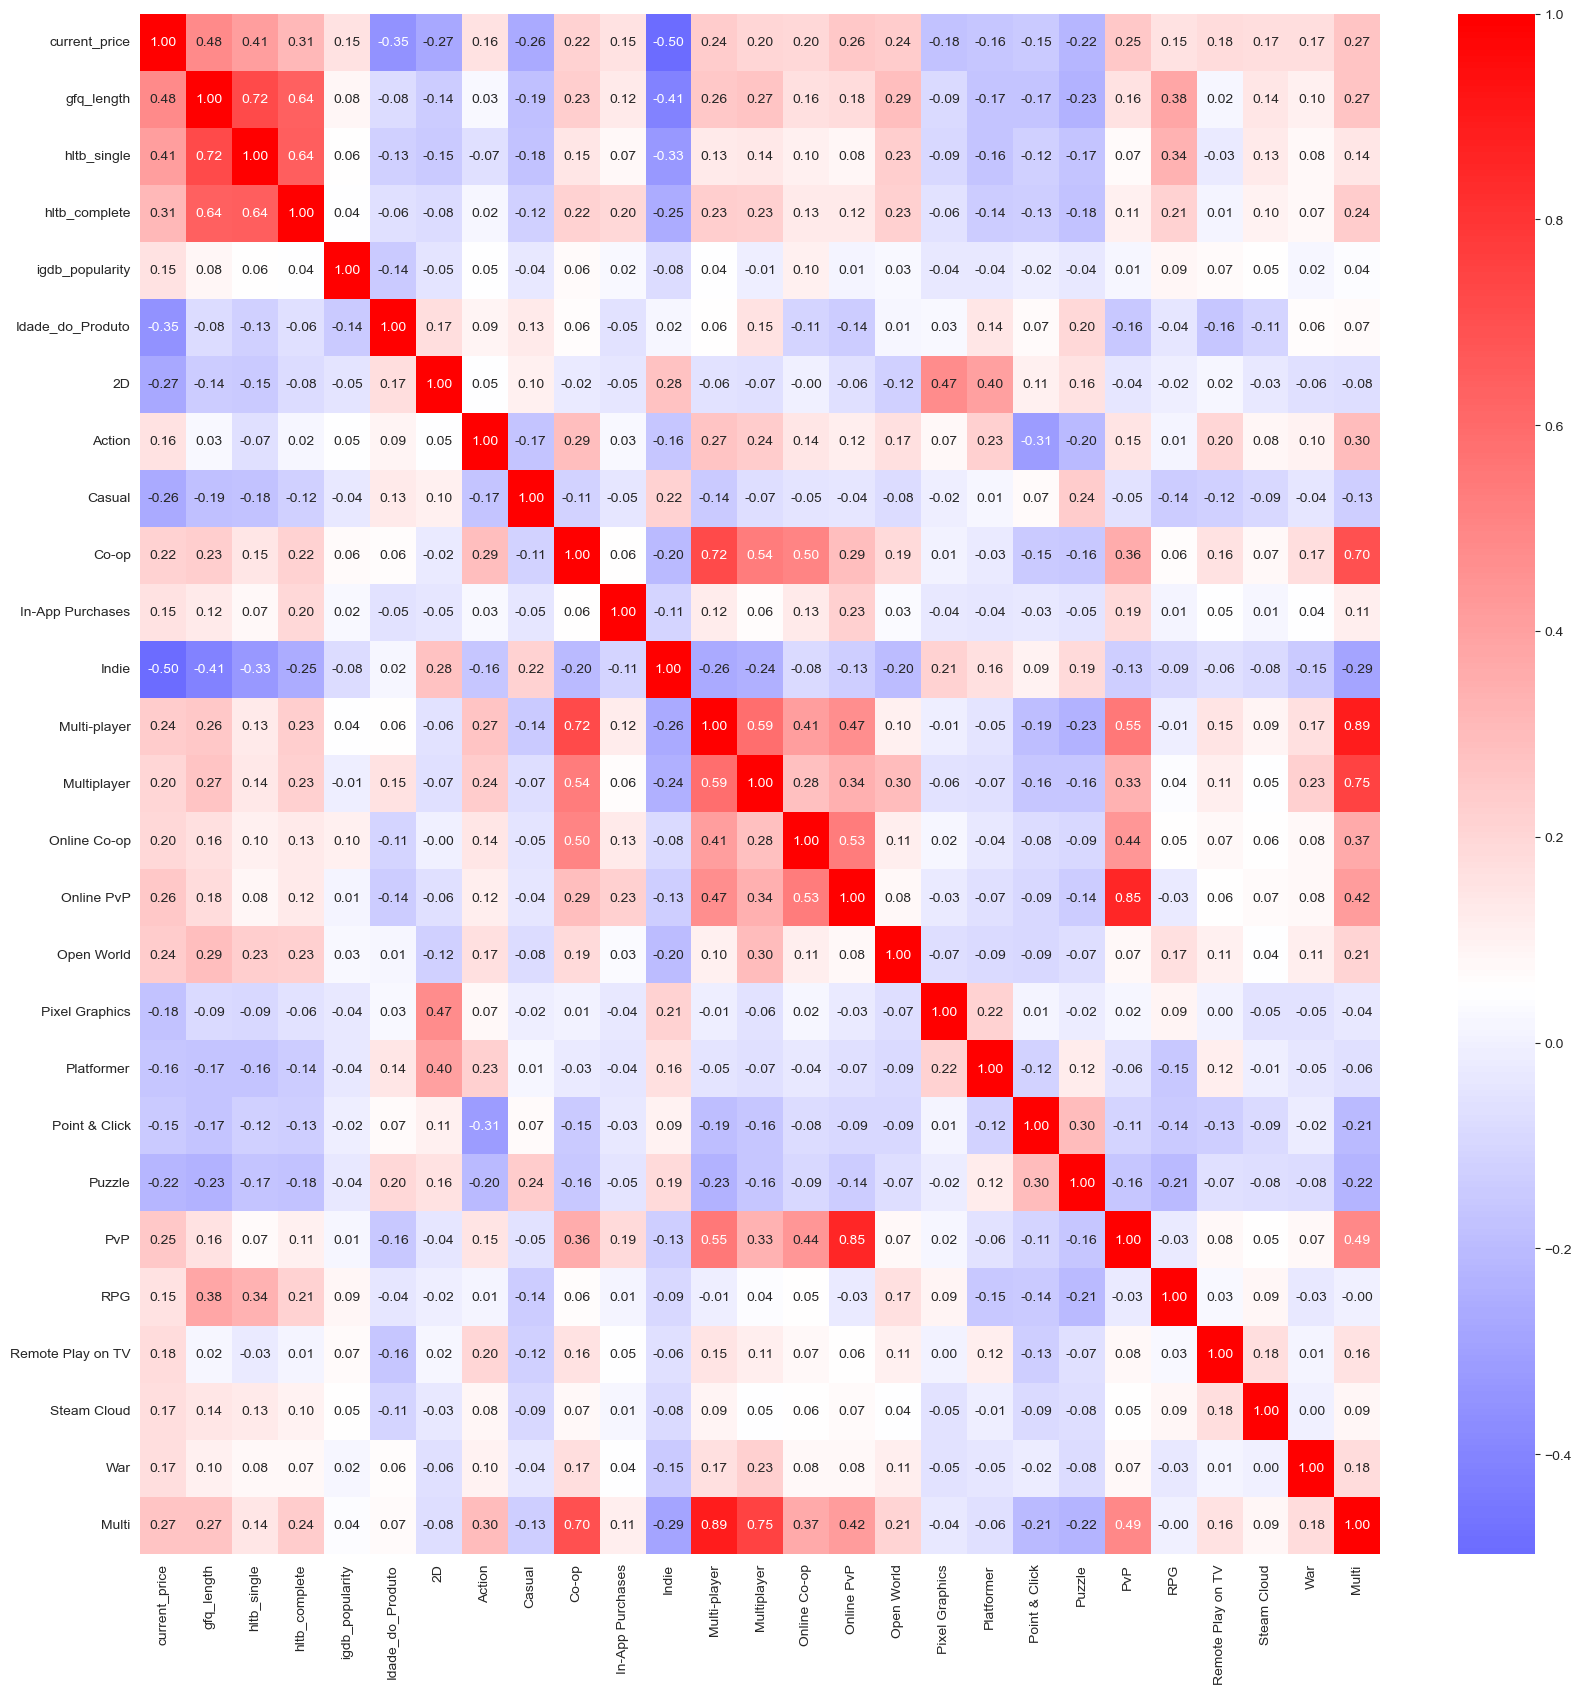

In [541]:
corr_matrix = df_encoded.corr()

# Filtrar colunas com correlação acima de um limiar (0.1 neste caso)
# Verificar primeiro se as colunas estão presentes no DataFrame
cols_to_keep = corr_matrix.columns[corr_matrix.abs()['current_price'] > 0.15]

# Criar uma nova matriz de correlação apenas com as colunas filtradas
filtered_corr_matrix = df_encoded[cols_to_keep].corr()

# Usar seaborn para criar um heatmap da matriz de correlação filtrada
plt.figure(figsize=(20, 20))
sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='bwr', center= 0.05)

# Mostrar o gráfico
plt.show()

C:\Users\Lucia\AppData\Local\Temp\ipykernel_16364\2765979710.py:32: RuntimeWarning: invalid value encountered in divide
  r_ajustados_crescimento = np.diff(r_ajustados_normalizados) / r_ajustados_normalizados[:-1]
C:\Users\Lucia\AppData\Local\Temp\ipykernel_16364\2765979710.py:33: RuntimeWarning: divide by zero encountered in divide
  f_statistics_crescimento = np.diff(f_statistics_normalizados) / f_statistics_normalizados[:-1]


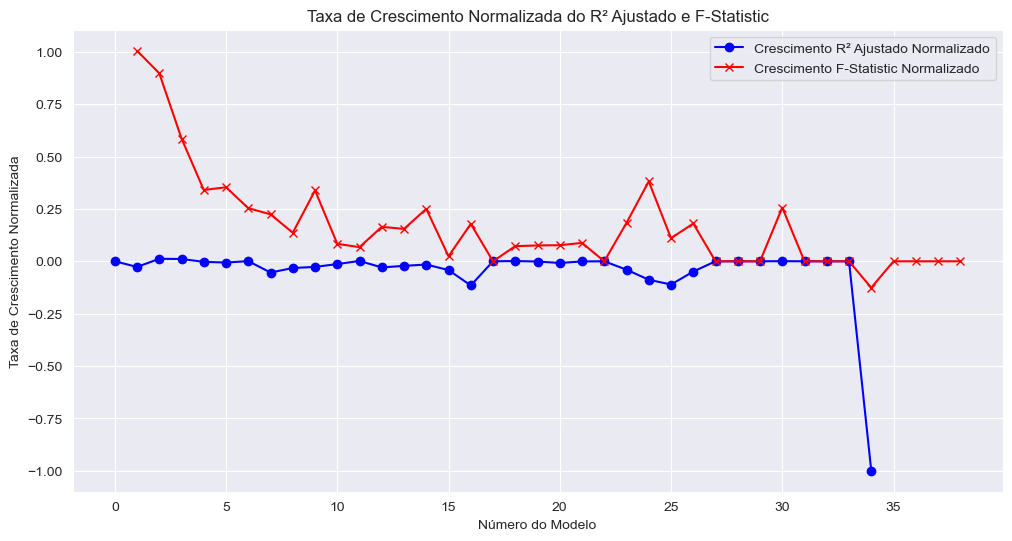

In [542]:
modelos = list(range(0, 39))
r_ajustados_modelo_1 = []
f_statistics_modelo_1 = []
limite = []
for i in range(40):
    corr_matrix = df_encoded.corr(numeric_only=True)
    multi = 0.01 + (0.01 * i)
    limite.append(multi)
    cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > multi]
    cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
    X = df_encoded[cols_to_keep]  # Variáveis independentes
    y = df_encoded['current_price']       # Variável dependente
    X_sm = sm.add_constant(X)
    model_sm = sm.OLS(y, X_sm).fit()


    adj_r_squared = model_sm.rsquared_adj
    f_statistic = model_sm.fvalue

    r_ajustados_modelo_1.append(adj_r_squared)
    f_statistics_modelo_1.append(f_statistic)


# Normalizar os dados
scaler = MinMaxScaler()

# Transformar R² ajustado e F-Statistic
r_ajustados_normalizados = scaler.fit_transform(np.array(r_ajustados_modelo_1).reshape(-1, 1)).flatten()
f_statistics_normalizados = scaler.fit_transform(np.array(f_statistics_modelo_1).reshape(-1, 1)).flatten()

# Calcular taxa de crescimento para os dados normalizados
r_ajustados_crescimento = np.diff(r_ajustados_normalizados) / r_ajustados_normalizados[:-1]
f_statistics_crescimento = np.diff(f_statistics_normalizados) / f_statistics_normalizados[:-1]

# Plotar gráficos
plt.figure(figsize=(12, 6))

# Curva de crescimento de R² Ajustado
plt.plot(modelos, r_ajustados_crescimento, label='Crescimento R² Ajustado Normalizado', color='blue', marker='o')

# Curva de crescimento de F-Statistic
plt.plot(modelos, f_statistics_crescimento, label='Crescimento F-Statistic Normalizado', color='red', marker='x')

plt.xlabel('Número do Modelo')
plt.ylabel('Taxa de Crescimento Normalizada')
plt.title('Taxa de Crescimento Normalizada do R² Ajustado e F-Statistic')
plt.legend()
plt.grid(True)
plt.show()

In [543]:
teste_p = set()
limite_p_valor = 0.05
for i in [0.05 , 0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    corr_matrix = df_encoded.corr(numeric_only=True)
    cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > i]
    cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
    X = df_encoded[cols_to_keep]  # Variáveis independentes
    y = df_encoded['current_price']       # Variável dependente
    X_sm = sm.add_constant(X)
    model_sm = sm.OLS(y, X_sm).fit()

    
    adj_r_squared = model_sm.rsquared_adj
    f_statistic = model_sm.fvalue
    

# Iterar sobre os pares de nomes de variáveis e seus valores-p
    for variavel, p_valor in model_sm.pvalues.items():
        if p_valor > limite_p_valor:
            teste_p.add(variavel)

print("Variáveis com valor-p alto:", teste_p)


Variáveis com valor-p alto: {'CRPG', 'Surreal', 'Historical', 'Massively Multiplayer', 'Platformer', 'Experimental', 'PvP', 'Shared/Split Screen PvP', 'Bullet Hell', 'Remote Play on Tablet', 'Atmospheric', 'Heist', 'hltb_complete', 'Sexual Content', 'Twin Stick Shooter', 'Noir', 'Fantasy', 'stsp_owners', 'MMORPG', 'RPGMaker', 'Economy', 'Competitive', 'Assassin', 'Real Time Tactics', 'MMO', 'Online PvP', 'Dark Fantasy', 'Hand-drawn', 'Remote Play Together', 'LAN Co-op', 'VR Only', '4X', 'LAN PvP', 'Open World', 'Violent', 'Relaxing', '2D', 'Co-op', 'Moddable', 'Anime', 'First-Person', 'Online Co-op', 'Short', 'Nudity', 'Side Scroller', 'City Builder', 'Quick-Time Events', 'Realistic', 'Sports', 'Retro', 'Fighting', 'Hidden Object', 'RPG', 'Steam Cloud', 'Turn-Based Strategy', 'Sandbox', 'Online Co-Op', 'RTS', 'Parkour', 'Third-Person Shooter', 'Valve Anti-Cheat enabled', 'Simulation', "Shoot 'Em Up", 'Military', 'Touch-Friendly', 'Steam Leaderboards', 'gfq_rating', 'Building', 'Gore', 

0.08 0.16 0.24 0.35

corr |0.06 |0.17 |0.25 |0.35
R aj |54   |49   |47   |44
F-S  |28   |122  |221  |490

In [544]:
df_encoded = df_encoded.drop(columns=list(teste_p))
#df_encoded = df_encoded.drop(columns=['hltb_complete','Multiplayer', 'Puzzle', 'PvP'])

C:\Users\Lucia\AppData\Local\Temp\ipykernel_16364\419426548.py:27: RuntimeWarning: invalid value encountered in divide
  r_ajustados_crescimento = np.diff(r_ajustados_normalizados) / r_ajustados_normalizados[:-1]
C:\Users\Lucia\AppData\Local\Temp\ipykernel_16364\419426548.py:28: RuntimeWarning: divide by zero encountered in divide
  f_statistics_crescimento = np.diff(f_statistics_normalizados) / f_statistics_normalizados[:-1]


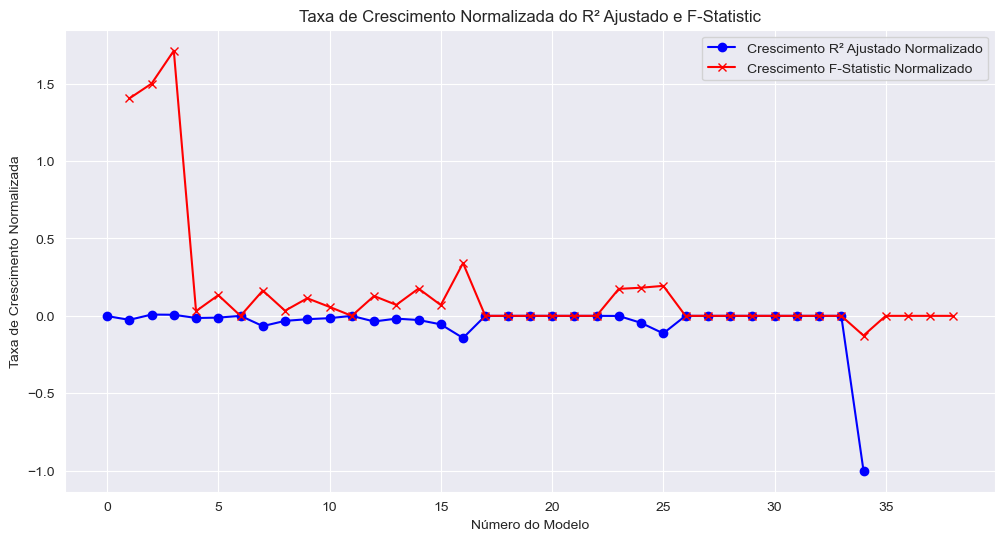

In [545]:
r_ajustados_modelo_2 = []
f_statistics_modelo_2 = []
for i in range(40):
    corr_matrix = df_encoded.corr(numeric_only=True)
    multi = 0.01 + (0.01 * i)
    cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > multi]
    cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
    X = df_encoded[cols_to_keep]  # Variáveis independentes
    y = df_encoded['current_price']       # Variável dependente
    X_sm = sm.add_constant(X)
    model_sm = sm.OLS(y, X_sm).fit()


    adj_r_squared = model_sm.rsquared_adj
    f_statistic = model_sm.fvalue

    r_ajustados_modelo_2.append(adj_r_squared)
    f_statistics_modelo_2.append(f_statistic)
    
scaler = MinMaxScaler()

# Transformar R² ajustado e F-Statistic
r_ajustados_normalizados = scaler.fit_transform(np.array(r_ajustados_modelo_2).reshape(-1, 1)).flatten()
f_statistics_normalizados = scaler.fit_transform(np.array(f_statistics_modelo_2).reshape(-1, 1)).flatten()

# Calcular taxa de crescimento para os dados normalizados
r_ajustados_crescimento = np.diff(r_ajustados_normalizados) / r_ajustados_normalizados[:-1]
f_statistics_crescimento = np.diff(f_statistics_normalizados) / f_statistics_normalizados[:-1]

# Plotar gráficos
plt.figure(figsize=(12, 6))

# Curva de crescimento de R² Ajustado
plt.plot(modelos, r_ajustados_crescimento, label='Crescimento R² Ajustado Normalizado', color='blue', marker='o')

# Curva de crescimento de F-Statistic
plt.plot(modelos, f_statistics_crescimento, label='Crescimento F-Statistic Normalizado', color='red', marker='x')

plt.xlabel('Número do Modelo')
plt.ylabel('Taxa de Crescimento Normalizada')
plt.title('Taxa de Crescimento Normalizada do R² Ajustado e F-Statistic')
plt.legend()
plt.grid(True)
plt.show()

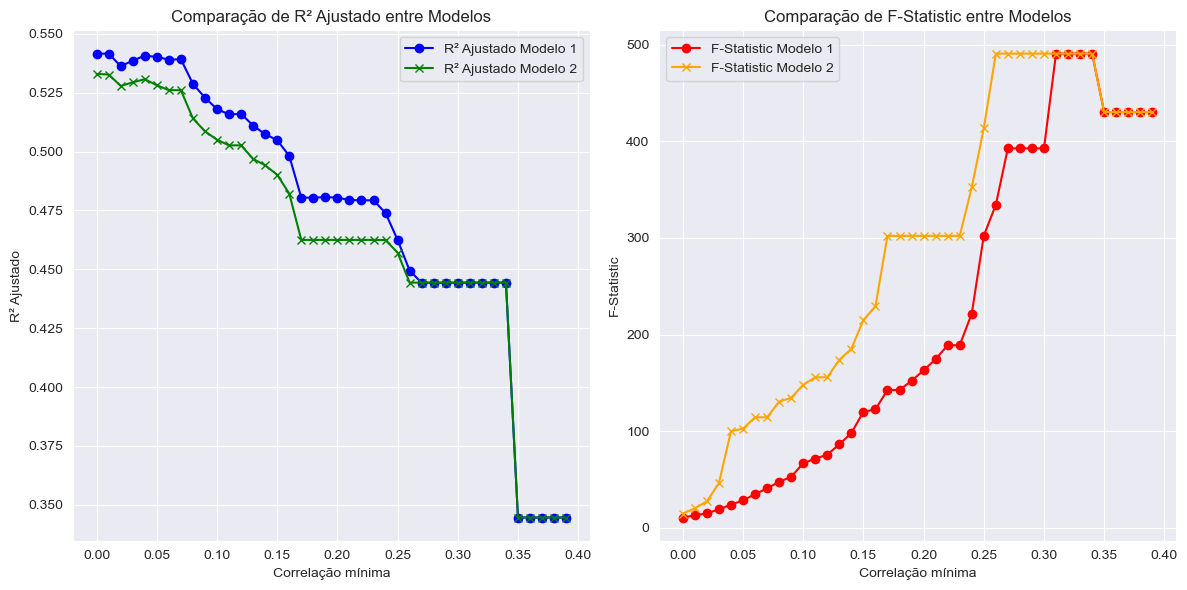

In [546]:
modelos = list(range(len(r_ajustados_modelo_1)))
modelos = [x/100 for x in modelos]
# Plotar gráficos
plt.figure(figsize=(12, 6))

# Comparação de R² Ajustado
plt.subplot(1, 2, 1)
plt.plot(modelos, r_ajustados_modelo_1, label='R² Ajustado Modelo 1', color='blue', marker='o')
plt.plot(modelos, r_ajustados_modelo_2, label='R² Ajustado Modelo 2', color='green', marker='x')
plt.xlabel('Correlação mínima')
plt.ylabel('R² Ajustado')
plt.title('Comparação de R² Ajustado entre Modelos')
plt.legend()

# Comparação de F-Statistic
plt.subplot(1, 2, 2)
plt.plot(modelos, f_statistics_modelo_1, label='F-Statistic Modelo 1', color='red', marker='o')
plt.plot(modelos, f_statistics_modelo_2, label='F-Statistic Modelo 2', color='orange', marker='x')
plt.xlabel('Correlação mínima')
plt.ylabel('F-Statistic')
plt.title('Comparação de F-Statistic entre Modelos')
plt.legend()

plt.tight_layout()
plt.show()

Agora que podemos observar claramente a diferença entre os mais diversos limites de correlação para adicão de variáveis dependentes no modelo
e após termos retirado todas as colunas que poderiam ter casos de insignificância, podemos prosseguir testando polinômios de graus maiores e seus resíduos.

### Testar limites em graus diferentes:

C:\Users\Lucia\AppData\Local\Temp\ipykernel_16364\2727194632.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df_encoded.corr()


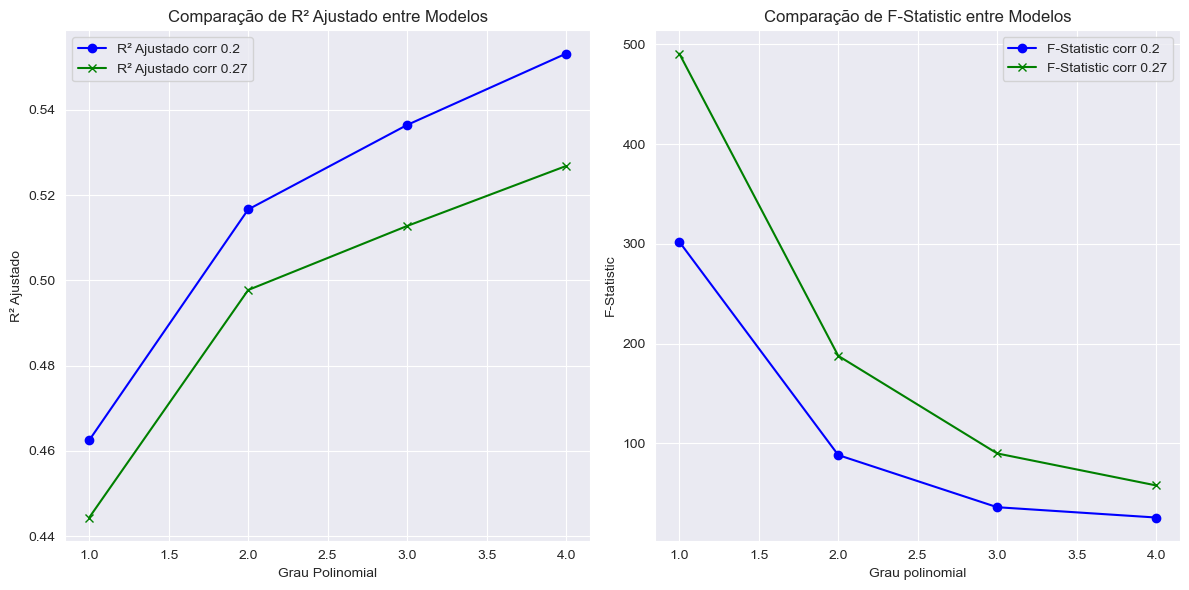

In [547]:

corr_matrix = df_encoded.corr()
r_ajustados_poli_corr_2=[]
r_ajustados_poli_corr_27=[]
f_statistics_poli_corr_2=[]
f_statistics_poli_corr_27=[]
for i in [0.2,0.27]:
    cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > i]
    cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
    X = df_encoded[cols_to_keep]  # Variáveis independentes
    y = df_encoded['current_price']
    
    for degree in range(1, 5):  # Graus 1 a 5
        poly = PolynomialFeatures(degree)
        X_poly = poly.fit_transform(X)

        X_sm_poly = sm.add_constant(X_poly)
        model_sm_poly = sm.OLS(y, X_sm_poly).fit()

        # Extrair R² ajustado e F-statistic
        adj_r_squared = model_sm_poly.rsquared_adj
        f_statistic = model_sm_poly.fvalue

        if i<0.27:
            r_ajustados_poli_corr_2.append(adj_r_squared)
            f_statistics_poli_corr_2.append(f_statistic)
        else:
            r_ajustados_poli_corr_27.append(adj_r_squared)
            f_statistics_poli_corr_27.append(f_statistic)

modelos = list(range(1,len(r_ajustados_poli_corr_2)+1))          
plt.figure(figsize=(12, 6))

# Comparação de R² Ajustado
plt.subplot(1, 2, 1)
plt.plot(modelos, r_ajustados_poli_corr_2, label='R² Ajustado corr 0.2', color='blue', marker='o')
plt.plot(modelos, r_ajustados_poli_corr_27, label='R² Ajustado corr 0.27', color='green', marker='x')
plt.xlabel('Grau Polinomial')
plt.ylabel('R² Ajustado')
plt.title('Comparação de R² Ajustado entre Modelos')
plt.legend()

# Comparação de F-Statistic
plt.subplot(1, 2, 2)
plt.plot(modelos, f_statistics_poli_corr_2, label='F-Statistic corr 0.2', color='blue', marker='o')
plt.plot(modelos, f_statistics_poli_corr_27, label='F-Statistic corr 0.27', color='green', marker='x')
plt.xlabel('Grau polinomial')
plt.ylabel('F-Statistic')
plt.title('Comparação de F-Statistic entre Modelos')
plt.legend()

plt.tight_layout()
plt.show()
            


A julgar pelos resultados acredito que o limite de 0.27 seja melhor ajustado em segundo grau, sacrificando um pouco de generalização por significância
mas não perdendo tanta generalização. qualquer coisa além de um polinomio de segundo grau parece perder muito. vejamos um exemplo extremo de cada. max de R ajustado, Max de F-stat e meio termo.

Resultados do Modelo - Grau 4:

R² Ajustado: 0.5532227852158738
F-Statistic: 25.66436934889169

Resultados do Modelo - Grau 1:

R² Ajustado: 0.4443382384302862
F-Statistic: 490.78927444948033

Resultados do Modelo - Grau 2:

R² Ajustado: 0.49774124807478315
F-Statistic: 187.76644460325278


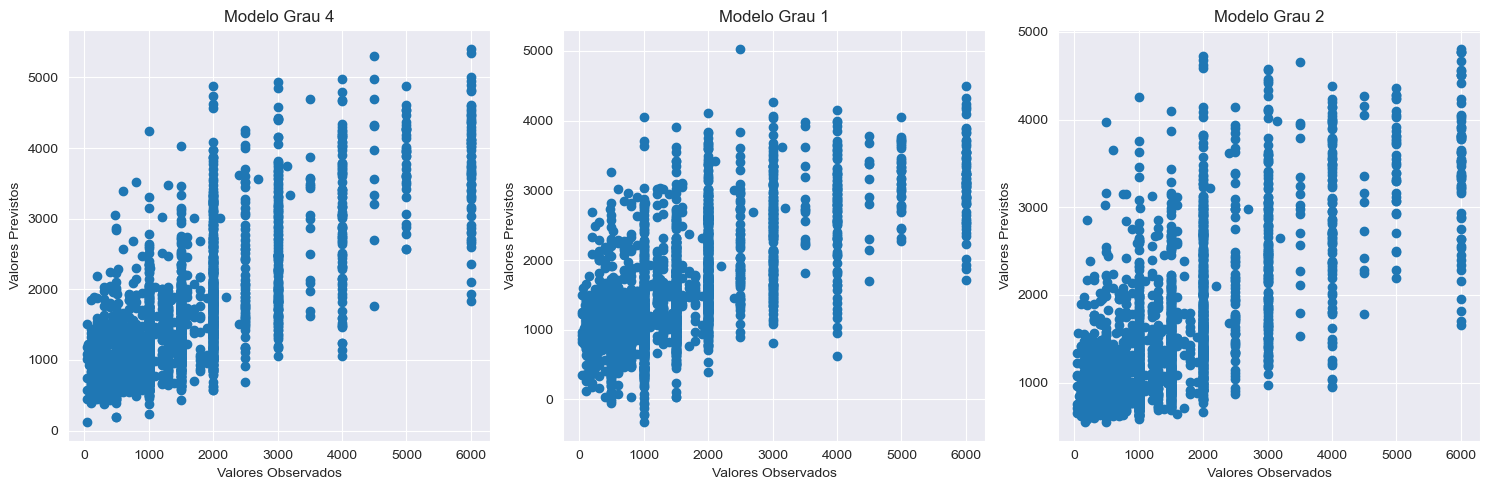

In [548]:
# Plotar gráficos lado a lado
plt.figure(figsize=(15, 5))

cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > 0.2]
cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
X = df_encoded[cols_to_keep]  # Variáveis independentes
y = df_encoded['current_price']

poly = PolynomialFeatures(4)
X_poly1 = poly.fit_transform(X)

X_sm_poly1 = sm.add_constant(X_poly1)
model_sm_poly1 = sm.OLS(y, X_sm_poly1).fit()

adj_r_squared = model_sm_poly1.rsquared_adj
f_statistic = model_sm_poly1.fvalue

# Extrair e imprimir os valores-p
print(f"Resultados do Modelo - Grau {4}:\n")
print(f"R² Ajustado: {adj_r_squared}")
print(f"F-Statistic: {f_statistic}\n")

y_pred1 = model_sm_poly1.predict(X_sm_poly1)


# Gráfico para o Modelo 1
plt.subplot(1, 3, 1)  # 1 linha, 3 colunas, 1º gráfico
plt.scatter(y, y_pred1)
plt.xlabel('Valores Observados')
plt.ylabel('Valores Previstos')
plt.title('Modelo Grau 4')

cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > 0.27]
cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
X = df_encoded[cols_to_keep]  # Variáveis independentes
y = df_encoded['current_price']

poly = PolynomialFeatures(1)
X_poly2 = poly.fit_transform(X)

X_sm_poly2 = sm.add_constant(X_poly2)
model_sm_poly2 = sm.OLS(y, X_sm_poly2).fit()

adj_r_squared = model_sm_poly2.rsquared_adj
f_statistic = model_sm_poly2.fvalue

# Extrair e imprimir os valores-p
print(f"Resultados do Modelo - Grau {1}:\n")
print(f"R² Ajustado: {adj_r_squared}")
print(f"F-Statistic: {f_statistic}\n")

y_pred2 = model_sm_poly2.predict(X_sm_poly2)

# Gráfico para o Modelo 2
plt.subplot(1, 3, 2)  # 1 linha, 3 colunas, 2º gráfico
plt.scatter(y, y_pred2)
plt.xlabel('Valores Observados')
plt.ylabel('Valores Previstos')
plt.title('Modelo Grau 1')


poly = PolynomialFeatures(2)
X_poly3 = poly.fit_transform(X)

X_sm_poly3 = sm.add_constant(X_poly3)
model_sm_poly3 = sm.OLS(y, X_sm_poly3).fit()

adj_r_squared = model_sm_poly3.rsquared_adj
f_statistic = model_sm_poly3.fvalue

# Extrair e imprimir os valores-p
print(f"Resultados do Modelo - Grau {2}:\n")
print(f"R² Ajustado: {adj_r_squared}")
print(f"F-Statistic: {f_statistic}\n")

y_pred1 = model_sm_poly1.predict(X_sm_poly1)
y_pred3 = model_sm_poly3.predict(X_sm_poly3)

# Gráfico para o Modelo 3
plt.subplot(1, 3, 3)  # 1 linha, 3 colunas, 3º gráfico
plt.scatter(y, y_pred3)
plt.xlabel('Valores Observados')
plt.ylabel('Valores Previstos')
plt.title('Modelo Grau 2')

plt.tight_layout()
plt.show()

## PUTZ estou Lascado, claramente tanto os dados, quanto os residuos seguem um padrão de heterocedasticidade
##### quase todos os valores parecem agir de maneira categórica, podemos obeservar nas previsões e valores reais, que o preço
##### parece se manter em regiões como 3000, 4000, 5000. O modelo não se adequa bem para esse tipo de dado, talvez seja melhor 
##### fazer um modelo logistico e tentar prever de maneira categórica.

## **TESTE DE PREVISÕES E RESÍDUOS** 

In [549]:
residuos1 = y - y_pred1
residuos2 = y - y_pred2
residuos3 = y - y_pred3
# Modelo 1
shapiro_test1 = stats.shapiro(residuos1)
print("Shapiro-Wilk Modelo 1:", shapiro_test1)

# Modelo 2
shapiro_test2 = stats.shapiro(residuos2)
print("Shapiro-Wilk Modelo 2:", shapiro_test2)

# Modelo 3
shapiro_test3 = stats.shapiro(residuos3)
print("Shapiro-Wilk Modelo 3:", shapiro_test3)

Shapiro-Wilk Modelo 1: ShapiroResult(statistic=0.9594087600708008, pvalue=1.2319158812127258e-25)
Shapiro-Wilk Modelo 2: ShapiroResult(statistic=0.9560855031013489, pvalue=1.4545974172461387e-26)
Shapiro-Wilk Modelo 3: ShapiroResult(statistic=0.9544305801391602, pvalue=5.254419141146454e-27)


In [550]:
# Modelo 1
bp_test1 = sm.stats.diagnostic.het_breuschpagan(residuos1, model_sm_poly1.model.exog)
print("Breusch-Pagan Modelo 1:", bp_test1)

# Modelo 2
bp_test2 = sm.stats.diagnostic.het_breuschpagan(residuos2, model_sm_poly2.model.exog)
print("Breusch-Pagan Modelo 2:", bp_test2)

# Modelo 3
bp_test3 = sm.stats.diagnostic.het_breuschpagan(residuos3, model_sm_poly3.model.exog)
print("Breusch-Pagan Modelo 3:", bp_test3)

Breusch-Pagan Modelo 1: (532.5487628788221, 7.904249852900093e-12, 5.251699731720993, 3.474126534979318e-61)
Breusch-Pagan Modelo 2: (393.3356230315303, 7.6593275896102285e-84, 116.89211135498337, 2.4279799583046034e-91)
Breusch-Pagan Modelo 3: (409.8499962984154, 1.0648333527728621e-78, 37.64108992735718, 2.659639193163288e-87)


In [551]:
# Substitua 'caminho_para_salvar/arquivo.csv' pelo caminho e nome do arquivo desejado
df_encoded.to_csv('arquivo.csv', index=False)


Primeiramente vamos ver a distribuição de current_price, devia ter visto desde o início.

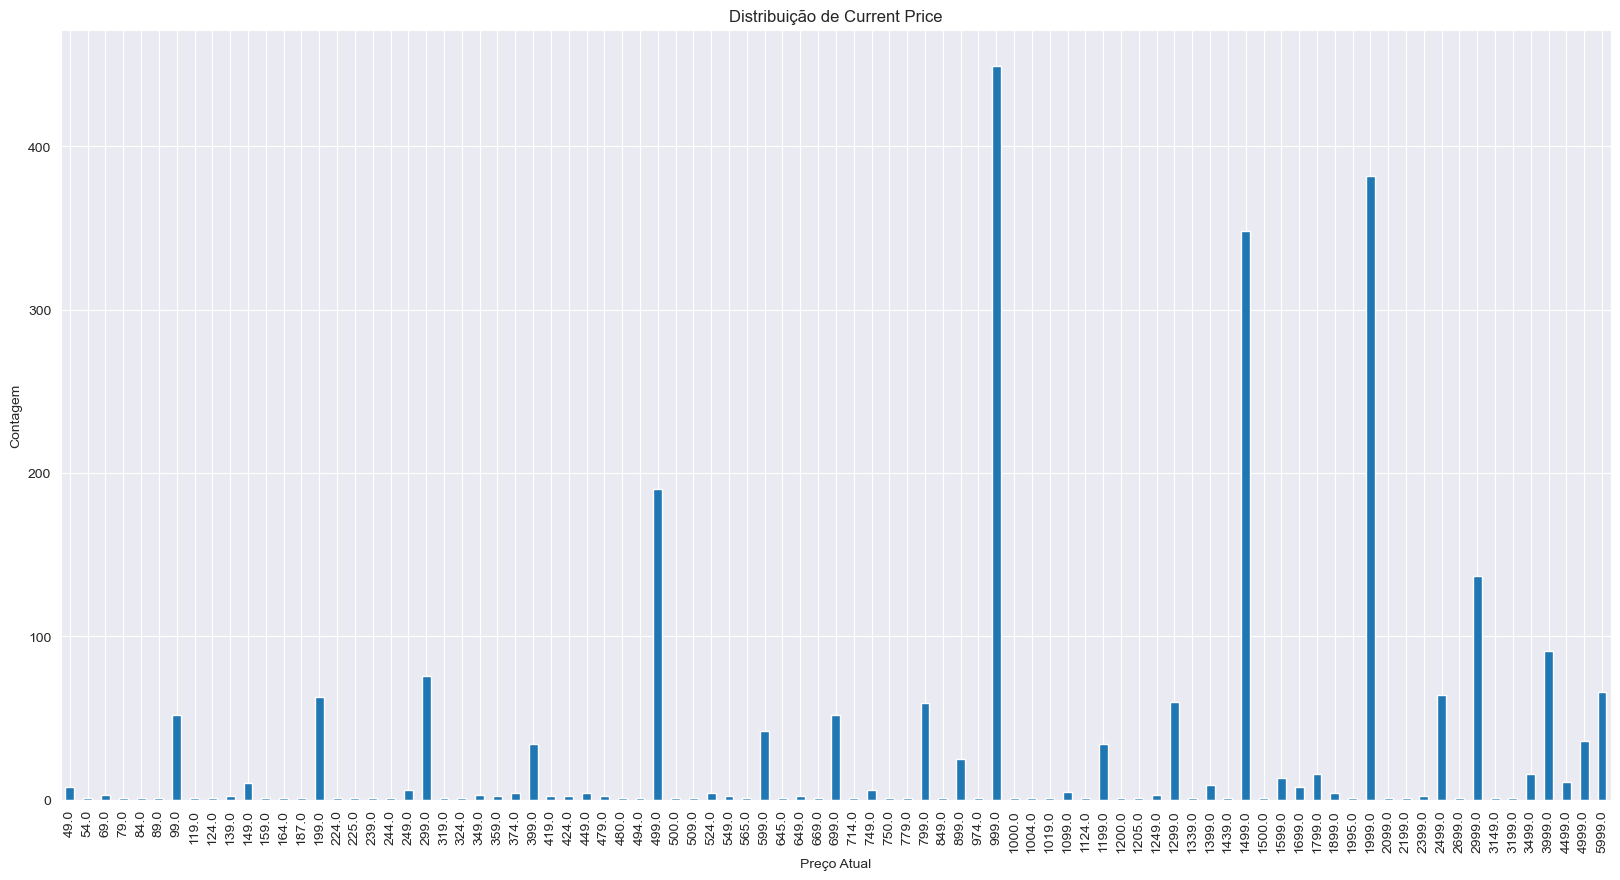

In [521]:
plt.figure(figsize=(20, 10))
df_encoded['current_price'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Preço Atual')
plt.ylabel('Contagem')
plt.title('Distribuição de Current Price')
plt.show()

Podemos observar claramente que a distribuição dos valores se concentram em alguns valores, portanto estipulemos um número mínimo de ocorrências para
fazer parte de uma coluna categorizada desses valores.

2000+        810
1000-1499    568
500-999      392
1500-1999    391
0-499        290
Name: current_price, dtype: int64


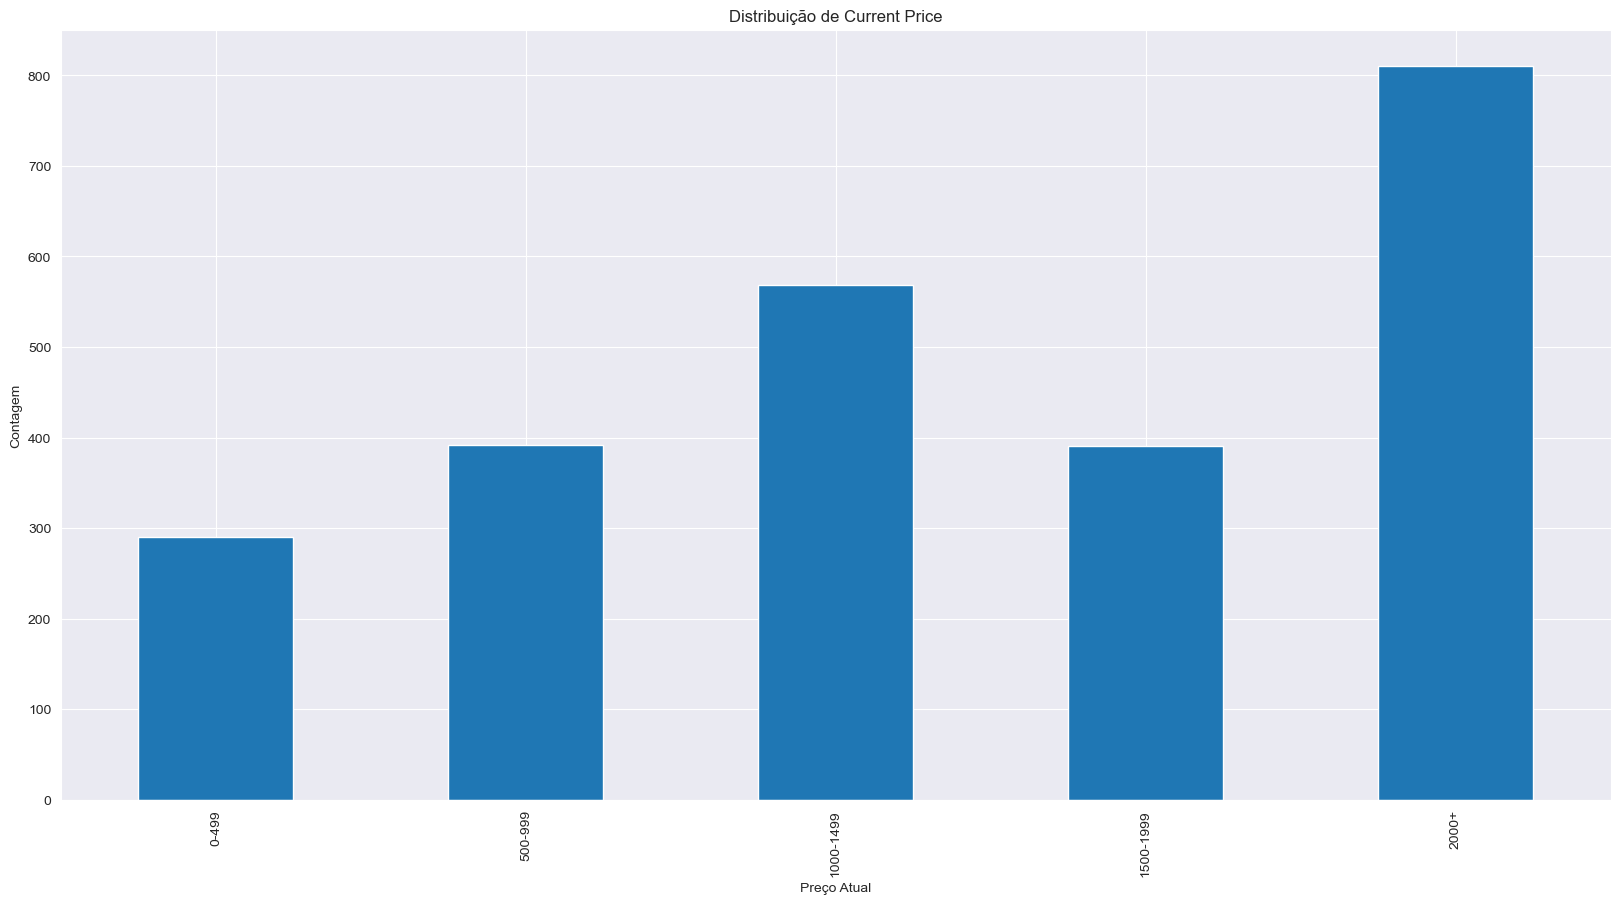

In [522]:
bins = [0, 499, 999, 1499, 1999, 6000]
labels = ['0-499', '500-999', '1000-1499', '1500-1999', '2000+']

# Categorizando os preços
df_encoded['current_price'] = pd.cut(df_encoded['current_price'], bins=bins, labels=labels, right=False)

# Verificar a distribuição das novas categorias
print(df_encoded['current_price'].value_counts())
plt.figure(figsize=(20, 10))
df_encoded['current_price'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Preço Atual')
plt.ylabel('Contagem')
plt.title('Distribuição de Current Price')
plt.show()

podemos testar o modelo logistico com esse número de categorias

In [523]:
df_encoded['current_price'] = df_encoded['current_price'].astype('category')
df_encoded['current_price'].info()
df_encoded['current_price'].nunique()

<class 'pandas.core.series.Series'>
Int64Index: 2451 entries, 9 to 34727
Series name: current_price
Non-Null Count  Dtype   
--------------  -----   
2451 non-null   category
dtypes: category(1)
memory usage: 21.7 KB


5

In [526]:
cols_to_keep = corr_matrix.index[corr_matrix.abs()['current_price'] > 0.1]
cols_to_keep = cols_to_keep.drop('current_price')  # Remover a coluna 'score' da lista
X = df_encoded[cols_to_keep]  # Variáveis independentes
y = df_encoded['current_price']

# Adicionando uma constante ao modelo
X = sm.add_constant(X)

modelo_logistico_multinomial = sm.MNLogit(y, X).fit()

# Exibir o sumário do modelo
print(modelo_logistico_multinomial.summary())

         Current function value: 1.202693
         Iterations: 35


C:\Users\Lucia\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                          MNLogit Regression Results                          
Dep. Variable:          current_price   No. Observations:                 2451
Model:                        MNLogit   Df Residuals:                     2371
Method:                           MLE   Df Model:                           76
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                  0.2207
Time:                        14:27:14   Log-Likelihood:                -2947.8
converged:                      False   LL-Null:                       -3782.5
Covariance Type:            nonrobust   LLR p-value:                2.872e-298
  current_price=500-999       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -1.4053      0.644     -2.181      0.029      -2.668      -0.142
gfq_length                  0.0056      0.011      0.493      0.622      -0.017       0.028


In [492]:
df_encoded[cols_to_keep].describe()

,gfq_length,hltb_single,Idade_do_Produto,Indie
count,2326.000000,2326.000000,2326.000000,2326.000000
mean,19.543594,10.391660,3021.212812,0.691745
std,18.780170,12.687038,909.848201,0.461872
min,0.500000,1.000000,1343.000000,0.000000
25%,6.700000,3.000000,2324.250000,0.000000
50%,12.000000,6.000000,2989.500000,1.000000
75%,25.375000,12.000000,3577.000000,1.000000
max,80.000000,187.000000,6959.000000,1.000000


In [493]:
for variavel in cols_to_keep:
    # Calcular Q1 (25º percentil) e Q3 (75º percentil)
    Q1 = df_encoded[variavel].quantile(0.25)
    Q3 = df_encoded[variavel].quantile(0.75)

    # Calcular o IQR (intervalo interquartil)
    IQR = Q3 - Q1

    # Definir limites para identificar outliers
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Filtrar outliers
    df_encoded = df_encoded[(df_encoded[variavel] >= limite_inferior) & (df_encoded[variavel] <= limite_superior)]

# Verificar o resultado após a remoção de outliers
print(df_encoded[cols_to_keep].describe())

        gfq_length  hltb_single  Idade_do_Produto   Indie
count  1478.000000  1478.000000       1478.000000  1478.0
mean     11.576725     5.587280       3035.894452     1.0
std       9.324235     4.276041        827.477704     0.0
min       0.500000     1.000000       1363.000000     1.0
25%       5.300000     2.000000       2431.750000     1.0
50%       8.500000     4.000000       3038.500000     1.0
75%      14.575000     8.000000       3555.500000     1.0
max      52.300000    20.000000       5385.000000     1.0


In [494]:
X = df_encoded[cols_to_keep]  # Variáveis independentes
y = df_encoded['current_price']

# Adicionando uma constante ao modelo
X = sm.add_constant(X)

modelo_logistico_multinomial = sm.MNLogit(y, X).fit()

# Exibir o sumário do modelo
print(modelo_logistico_multinomial.summary())

C:\Users\Lucia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
C:\Users\Lucia\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:          current_price   No. Observations:                 1478
Model:                        MNLogit   Df Residuals:                     1386
Method:                           MLE   Df Model:                           69
Date:                Thu, 07 Dec 2023   Pseudo R-squ.:                     nan
Time:                        14:09:14   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -3649.0
Covariance Type:            nonrobust   LLR p-value:                       nan
 current_price=149       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
gfq_length                nan        nan        nan        nan         nan         nan
hltb_singl

In [496]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Ajustar o modelo de regressão logística
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Avaliar o modelo
predictions = model.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

        99.0       0.00      0.00      0.00        18
       149.0       0.00      0.00      0.00         3
       199.0       0.00      0.00      0.00        22
       299.0       0.00      0.00      0.00        26
       399.0       0.00      0.00      0.00        12
       499.0       0.22      0.10      0.14        39
       599.0       0.00      0.00      0.00        11
       699.0       0.00      0.00      0.00        12
       799.0       0.00      0.00      0.00        12
       899.0       0.00      0.00      0.00         5
       999.0       0.25      0.77      0.37        99
      1199.0       0.00      0.00      0.00         6
      1299.0       0.00      0.00      0.00        18
      1499.0       0.25      0.32      0.28        77
      1599.0       0.00      0.00      0.00         4
      1799.0       0.00      0.00      0.00         2
      1999.0       0.24      0.08      0.11        53
      2499.0       0.00    

C:\Users\Lucia\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Lucia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lucia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in l